In [1]:
import pandas as pd
import numpy as np
from google.colab import files


In [2]:
uploaded=files.upload()
df=pd.read_csv('Online Retail.csv')

Saving Online Retail.csv to Online Retail.csv


In [3]:
df.dropna(subset=['CustomerID'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [4]:
df=df[df['Quantity']>0]
df=df[df['UnitPrice']>0]

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)


In [5]:
df['TotalPrice']=df['Quantity']*df['UnitPrice']

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [11]:
snapshot_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)

In [14]:
rfm=df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date-x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

In [15]:
rfm.columns=['CustomerID','Recency','Frequency','Monetary']

In [16]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [17]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


In [18]:
rfm_features=rfm[['Recency','Frequency','Monetary']]

In [19]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_features)

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss=[]

for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(rfm_scaled)
  wcss.append(kmeans.inertia_)

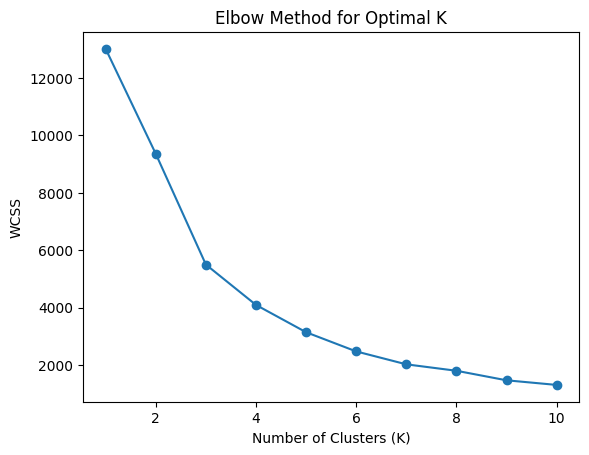

In [21]:
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


In [29]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [30]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,1
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


In [31]:
rfm.groupby('Cluster').mean()

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15282.157846,40.983906,4.852677,2012.111620
1,15354.225984,246.023788,1.582800,631.141410
2,15310.642857,7.142857,80.214286,122888.407143


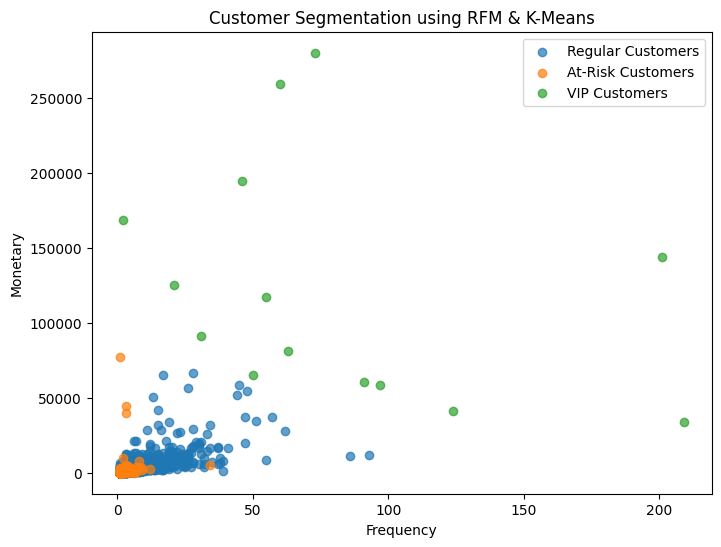

In [38]:
import matplotlib.pyplot as plt

cluster_labels = {
    0: 'Regular Customers',
    1: 'At-Risk Customers',
    2: 'VIP Customers'
}

plt.figure(figsize=(8,6))

for cluster, label in cluster_labels.items():
    subset = rfm[rfm['Cluster'] == cluster]
    plt.scatter(
        subset['Frequency'],
        subset['Monetary'],
        label=label,
        alpha=0.7
    )

plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segmentation using RFM & K-Means')
plt.legend()
plt.show()


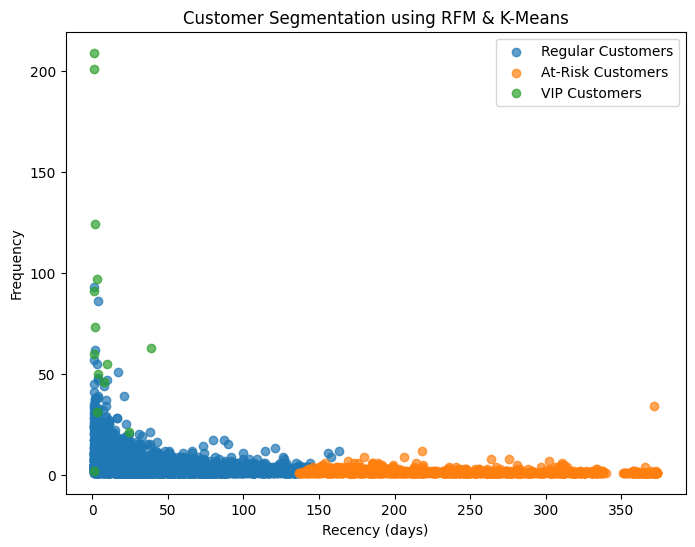

In [36]:
import matplotlib.pyplot as plt

cluster_labels = {
    0: 'Regular Customers',
    1: 'At-Risk Customers',
    2: 'VIP Customers'
}

plt.figure(figsize=(8,6))

for cluster, label in cluster_labels.items():
    subset = rfm[rfm['Cluster'] == cluster]
    plt.scatter(
        subset['Recency'],
        subset['Frequency'],
        label=label,
        alpha=0.7
    )

plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Customer Segmentation using RFM & K-Means')
plt.legend()
plt.show()


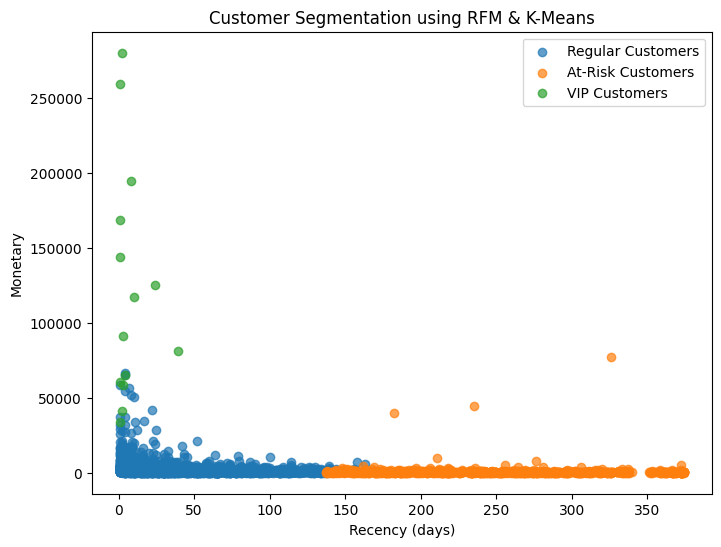

In [39]:
import matplotlib.pyplot as plt

cluster_labels = {
    0: 'Regular Customers',
    1: 'At-Risk Customers',
    2: 'VIP Customers'
}

plt.figure(figsize=(8,6))

for cluster, label in cluster_labels.items():
    subset = rfm[rfm['Cluster'] == cluster]
    plt.scatter(
        subset['Recency'],
        subset['Monetary'],
        label=label,
        alpha=0.7
    )

plt.xlabel('Recency (days)')
plt.ylabel('Monetary')
plt.title('Customer Segmentation using RFM & K-Means')
plt.legend()
plt.show()


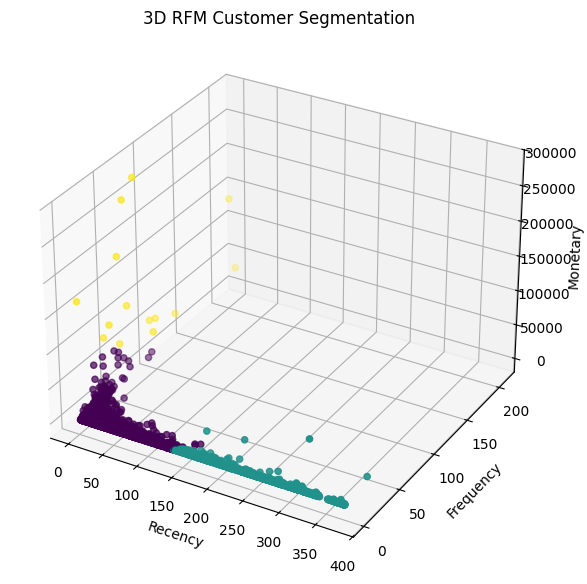

In [35]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    rfm['Recency'],
    rfm['Frequency'],
    rfm['Monetary'],
    c=rfm['Cluster']
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D RFM Customer Segmentation')

plt.show()
